# CMM706 - Text Analytics Coursework
Kaneel Dias  
IIT ID: 20242001  
RGU ID: 2506673

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk import ngrams
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
from keras import Sequential, Input
from keras.src.layers import Dense, Dropout
from keras.src.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, rand_score, jaccard_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kanee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
C:\Users\kanee\.virtualenvs\sri-lanka-hotel-reviews\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 1 - Describe the dataset

The data is saved in a CSV file, `reviews.csv`. We can read this file and display the first few rows to understand its structure and contents.

In [2]:
reviews = pd.read_csv("reviews.csv")
reviews.head()

,review_id,review_url,location_id,hotel_name,city,timestamp,rating,title,text,travel_date,username,value_rating,room_rating,location_rating,cleanliness_rating,service_rating,sleep_rating
0,1016464488,https://www.tripadvisor.com/ShowUserReviews-g2...,11953119,Nh Collection Colombo,Colombo,2025-07-04T05:58:58Z,1,not a good stay,Found lighters in the toilet paper rolls in a ...,2025-06-30,Curious04015869441,NaN,NaN,NaN,NaN,NaN,NaN
1,1016435128,https://www.tripadvisor.com/ShowUserReviews-g2...,11953119,Nh Collection Colombo,Colombo,2025-07-04T01:38:54Z,5,Definitely recommend!,The hotel is just excellent! The food is so go...,2025-07-31,742saltanata,5.0,5.0,5.0,5.0,5.0,5.0
2,1016307864,https://www.tripadvisor.com/ShowUserReviews-g2...,11953119,Nh Collection Colombo,Colombo,2025-07-03T05:15:10Z,5,Wonderful stay,Comfortable stay..cooperative staff..fast serv...,2025-07-31,847shivanig,5.0,5.0,5.0,5.0,4.0,5.0
3,1016165618,https://www.tripadvisor.com/ShowUserReviews-g2...,11953119,Nh Collection Colombo,Colombo,2025-07-02T06:36:14Z,5,My favorite 4+ star hotel in Colombo,"We live in New York area, but my spouse is fam...",2025-07-31,jacksF8984QN,NaN,NaN,NaN,NaN,NaN,NaN
4,1015472232,https://www.tripadvisor.com/ShowUserReviews-g2...,11953119,Nh Collection Colombo,Colombo,2025-06-28T00:50:47Z,5,Excellent food and stay,Excellent food especially indian corner lot of...,2025-06-30,Vinayaksahni,5.0,5.0,5.0,5.0,5.0,5.0


### 1.1. Nature of the data

As it can be seen, the dataset contains a collection of hotel reviews with the following columns:
- `review_id`: Unique identifier for each review (as provided by Trip Advisor).
- `review_url`: URL of the review on Trip Advisor.
- `location_id`: Unique identifier for the hotel (as provided by Trip Advisor).
- `hotel_name`: Name of the hotel.
- `city`: City where the hotel is located.
- `timestamp`: Date and time when the review was posted.
- `rating`: Rating given by the reviewer (1 to 5 stars).
- `title`: Title of the review.
- `text`: Full text of the review.
- `travel_date`: Date when the reviewer stayed at the hotel.
- `value_rating`: Rating for the value for money.
- `room_rating`: Rating for the room.
- `location_rating`: Rating for the location.
- `cleanliness_rating`: Rating for the cleanliness.
- `service_rating`: Rating for the service.
- `sleep_rating`: Rating for the sleep quality.

We can check the shape of the data to understand how many rows and columns are present in the dataset.

In [3]:
reviews.shape

(7367, 17)

As seen above, the dataset contains 7,367 reviews, with each review having 15 columns.

We can also check how many unique values are present in each column to understand the nature of the data.

In [4]:
reviews.nunique()

review_id             5186
review_url            5186
location_id            566
hotel_name             563
city                   161
timestamp             5186
rating                   5
title                 4691
text                  5186
travel_date            181
username              5019
value_rating             5
room_rating              5
location_rating          5
cleanliness_rating       5
service_rating           5
sleep_rating             5
dtype: int64

We can see that for most columns, there are exactly 5,186 unique columns, including for `review_id` this indicates that our dataset contains a significant number of duplicate reviews.

Aside from that, we can infer some additional information from the above.
- This dataset comprises reviews from 566 different hotels, each with its own unique `location_id`.
- There are 161 distinct cities represented in the dataset, each with its own unique `city` name.
- There are only 5 unique values for `rating`, which indicates that the ratings are on a 1 to 5 scale.
- There are 5,019 unique values for `username`, indicating that as many users have contributed multiple reviews.

### 1.2. Removing duplicates

Since the dataset contains duplicate reviews, we can remove them to ensure that each review is unique.

In [5]:
reviews = reviews.drop_duplicates()
reviews.shape

(5186, 17)

After removing duplicates, we have 5,186 unique reviews in the dataset.

### 1.2 Distribution of reviews by hotel

First, we can check the number of unique hotels in the dataset.

In [6]:
reviews["location_id"].unique().shape[0]

566

Next, we can visualize the number of reviews per hotel to understand the distribution of reviews across different hotels. We can use a histogram to visualize this distribution.

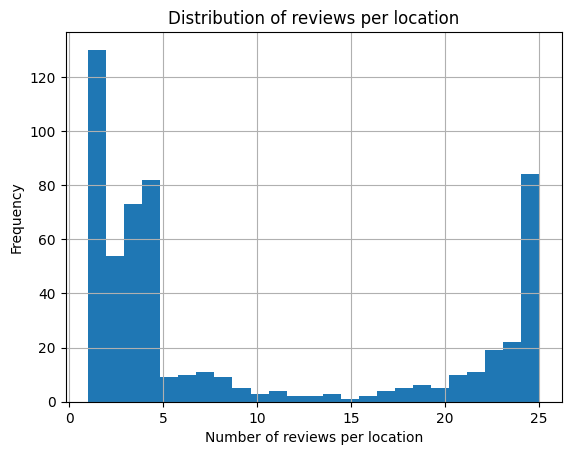

In [7]:
reviews["location_id"].value_counts().hist(bins=25)

plt.xlabel("Number of reviews per location")
plt.ylabel("Frequency")
plt.title("Distribution of reviews per location")
plt.show()

Here, we can see that most hotels have a small number of reviews.  Most hotels have between 1 and 5 reviews. This may due to a quirk of the Trip Advisor API, which only returns the 5 reviews per API request. You would need to make additional API calls with a different offset to get more reviews for each hotel. 

We can see a sharp drop-off after 5 reviews. This also may have something do with the API.

Finally, we can see a sharp spike at 25 reviews, and no hotels have more than 25 reviews. This is likely due to the API returning a maximum of 25 reviews per hotel.

### 1.3. Distribution of reviews by city

First, we can check the number of unique cities in the dataset.

In [8]:
reviews["city"].unique().shape[0]

161

Next, we can visualize the number of reviews per city to understand the distribution of reviews across different cities. We can use a histogram to visualize this distribution.

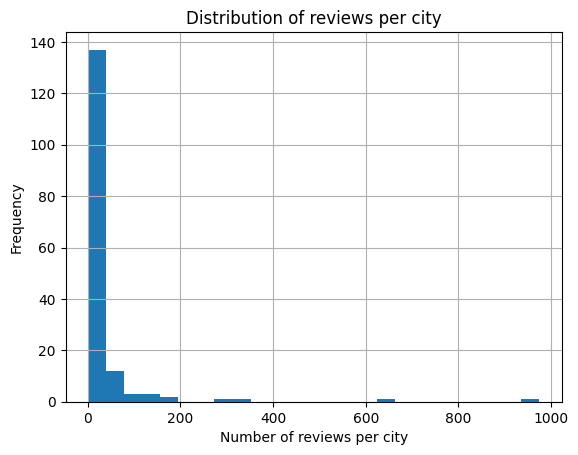

In [9]:
reviews["city"].value_counts().hist(bins=25)

plt.xlabel("Number of reviews per city")
plt.ylabel("Frequency")
plt.title("Distribution of reviews per city")
plt.show()

Here once again, we see a very unbalanced distribution of reviews across cities. Most cities have a small number of reviews, with a few cities having a large number of reviews. 

This can be explained by the fact that a few cities are more tourist/business hotspots. And a majority of the hotels as well as visitos are located in these cities.

We can also visualize the top 10 cities with the most reviews to get a better understanding of the distribution.

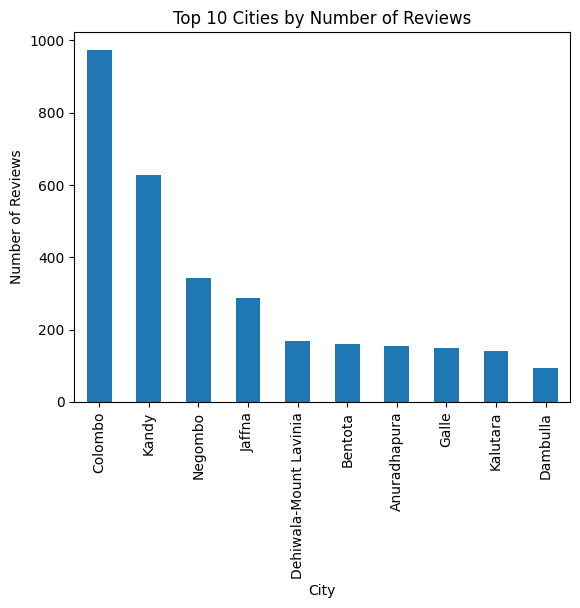

In [10]:
top_cities = reviews["city"].value_counts().head(10)

top_cities.plot(kind='bar')
plt.xlabel("City")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Cities by Number of Reviews")
plt.show()

Here, we can see the most populous cities in Sri Lanka are also the ones with the most reviews. Another factor affecting this may be how the data was collected using the API. 

As there were several interruptions/issues with the API, it is possible that the data collection was not uniform across all cities.

And now, we can visualize the number of unique hotels in each city to understand the distribution of hotels across different cities.

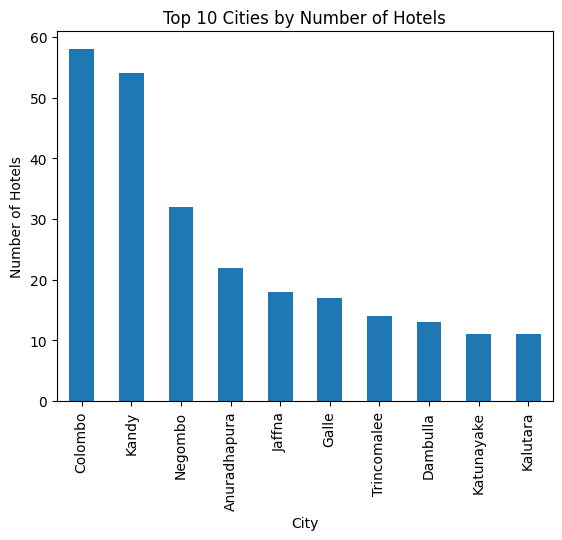

In [11]:
hotels_per_city = reviews.groupby("city")["location_id"].nunique().sort_values(ascending=False)
hotels_per_city.head(10).plot(kind='bar')
plt.xlabel("City")
plt.ylabel("Number of Hotels")
plt.title("Top 10 Cities by Number of Hotels")
plt.show()

This seems to follow the same pattern as the number of reviews per city. The most populous cities have the most hotels.

### 1.4. Distribution of ratings
We can now move onto checking the distribution of ratings in the dataset.

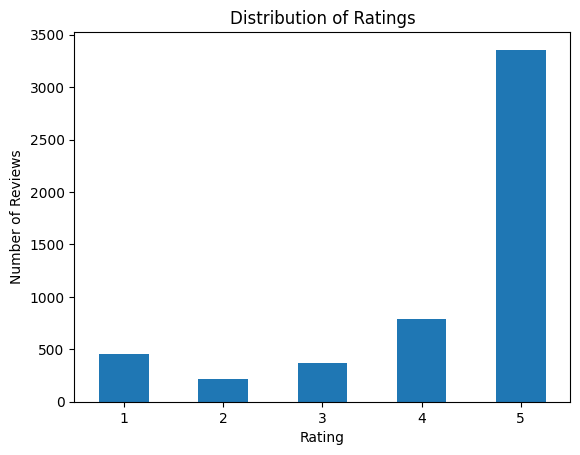

In [12]:
reviews["rating"].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Ratings")
plt.xticks(rotation=0)
plt.show()

As expected, it seems that most reviews are positive, with a majority of the reviews having a rating of 4 or 5 stars. This can be explained by the fact that people are more likely to leave a review if they had a positive experience.

But also, we do see a significant number of 1-star reviews, with a very low number of 2-star reviews. This may indicate that people are more likely to leave a review if they had a very positive or very negative experience, rather than a neutral experience.

We can also draw a boxplot to visualize the distribution of ratings and identify any potential outliers.

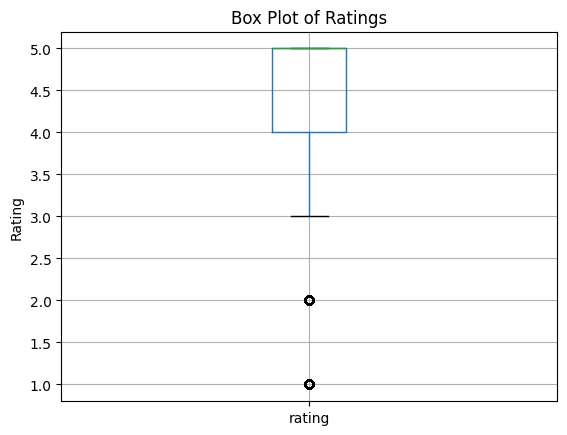

In [13]:
reviews.boxplot(column="rating")
plt.ylabel("Rating")
plt.title("Box Plot of Ratings")
plt.show()

We can also visualize the distribution of the average rating by hotel. This will help us understand how the ratings are distributed across different hotels.

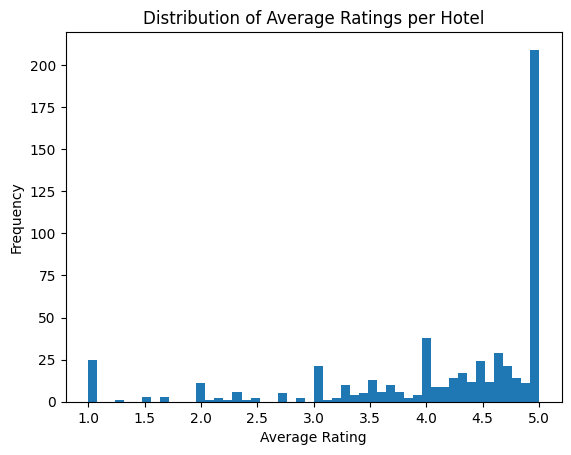

In [14]:
avg_rating_per_hotel = reviews.groupby("location_id")["rating"].mean().sort_values(ascending=False)

avg_rating_per_hotel.plot(kind='hist', bins=50)
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Average Ratings per Hotel")
plt.show()

Here, we see that a majority of hotels have a 5-star rating. This is unexpected, as we would expect a more balanced distribution of ratings across hotels. This may be due to the fact that the data was collected using the API, which may have a bias towards reviews with higher ratings.

We also see peaks at whole numbers. This may be because most hotels have one, two, or a very small number of reviews, and thus the average rating is likely to be a whole number.

We can do the same to analyze the distribution of average ratings by city. This will help us understand how the ratings are distributed across different cities.

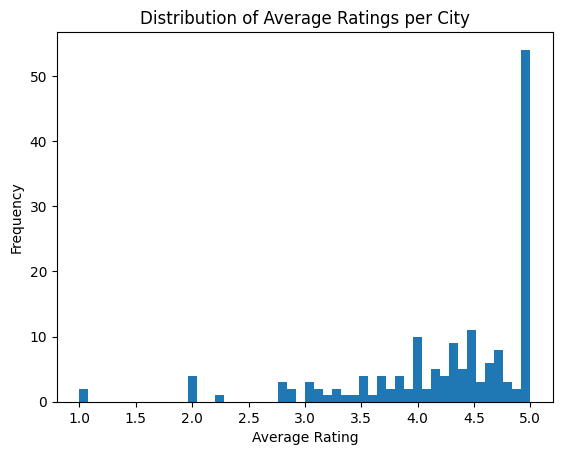

In [15]:
# Plot average rating for city, plot histogram of the average ratings
avg_rating_per_city = reviews.groupby("city")["rating"].mean().sort_values(ascending=False)
# histogram of average ratings
avg_rating_per_city.plot(kind='hist', bins=50)
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Average Ratings per City")
plt.show()

While here, we do see a similar pattern as the average ratings by hotel, we do see a more balanced distribution of ratings across cities. This may be due to the fact that there are more hotels in each city, and thus the average rating is less likely to be skewed by a small number of reviews.

### 1.5. Cleaning of text data

Now that we have described the dataset, we can move on to cleaning the text data. The text data consists of the `title` and `text` columns, which contain the title and full text of the review, respectively.

First, we can check the content of `title` column in the first few rows to understand its structure and contents.

In [16]:
reviews["title"].head(10)

0                         not a good stay
1                   Definitely recommend!
2                          Wonderful stay
3    My favorite 4+ star hotel in Colombo
4                 Excellent food and stay
5                             Outstanding
6                               I like it
7            Everything  is wonderful 😁😁😁
8                        Great experience
9          Very good and highly recommend
Name: title, dtype: object

We notice some flaws in this data which will affect us later on when we try to analyze the text data
- The titles are not in lowercase, which may affect our analysis later on.
- The titles contain punctuation, special characters, and emoji, which would affect our analysis.
- There is unnecessary whitespace in the titles, which may affect our analysis later on.

Our goal is to clean the text data so that it is in a consistent format, which will make it easier to analyze later on.

In [17]:
# convert title to lowercase
reviews["title"] = reviews["title"].str.lower()

# remove all non-alphanumeric
reviews["title"] = reviews["title"].str.replace(r'[^\w\s]', '', regex=True)

# remove unnecessary whitespace
reviews["title"] = reviews["title"].str.strip()
reviews['title'] = reviews['title'].str.replace(r'\s+', ' ', regex=True)

reviews["title"].head(10)

0                        not a good stay
1                   definitely recommend
2                         wonderful stay
3    my favorite 4 star hotel in colombo
4                excellent food and stay
5                            outstanding
6                              i like it
7                everything is wonderful
8                       great experience
9         very good and highly recommend
Name: title, dtype: object

And we can do the same for the `text` columns

In [18]:
# convert text to lowercase
reviews["text"] = reviews["text"].str.lower()

# remove all non-alphanumeric
reviews["text"] = reviews["text"].str.replace(r'[^\w\s]', '', regex=True)

# remove unnecessary whitespace
reviews["text"] = reviews["text"].str.strip()
reviews['text'] = reviews['text'].str.replace(r'\s+', ' ', regex=True)

reviews["text"].head(10)

0    found lighters in the toilet paper rolls in a ...
1    the hotel is just excellent the food is so goo...
2    comfortable staycooperative stafffast service ...
3    we live in new york area but my spouse is fami...
4    excellent food especially indian corner lot of...
5    spotless and immaculate premises the room is s...
6    house keeping and also respition i good and ni...
7    everything was amazing the breakfast and lunch...
8    we were there last week with our family and it...
9    very accommodating staff and lovely restaurant...
Name: text, dtype: object

Since the goal is to analyze the text data, we can combine the `title` and `text` columns into a single column called `review`. This will make it easier to analyze the text data later on.

In [19]:
# combine title and text
reviews["review"] = reviews["title"] + " " + reviews["text"]
reviews["review"].head(10)

0    not a good stay found lighters in the toilet p...
1    definitely recommend the hotel is just excelle...
2    wonderful stay comfortable staycooperative sta...
3    my favorite 4 star hotel in colombo we live in...
4    excellent food and stay excellent food especia...
5    outstanding spotless and immaculate premises t...
6    i like it house keeping and also respition i g...
7    everything is wonderful everything was amazing...
8    great experience we were there last week with ...
9    very good and highly recommend very accommodat...
Name: review, dtype: object

### 1.6. Analyzing the corpus

In [20]:
# total number of words
reviews["review"].str.split().str.len().sum()

481190

We can see that there are 481,190 words in the dataset.

In [21]:
# total number of unique words
reviews["review"].str.split().explode().nunique()

18137

There are 18,134 unique words in the corpus

Next we can visualize the distribution of review lengths to understand how long the reviews are. This will help us understand the nature of the reviews and how they vary in length.

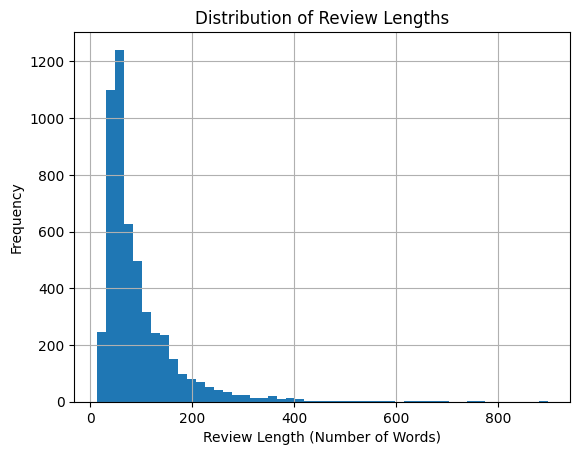

In [22]:
# distribution of review lengths
reviews["review_length"] = reviews["review"].str.split().str.len()
reviews["review_length"].hist(bins=50)
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

As expected. this distribution is highly skewed, with most reviews being relatively short. This is expected as most people would not take the time and make the effort to write long, detailed reviews.

Another interesting analysis would be to visualize the most frequent words in the reviews. This will help us understand the common themes and topics discussed in the reviews.

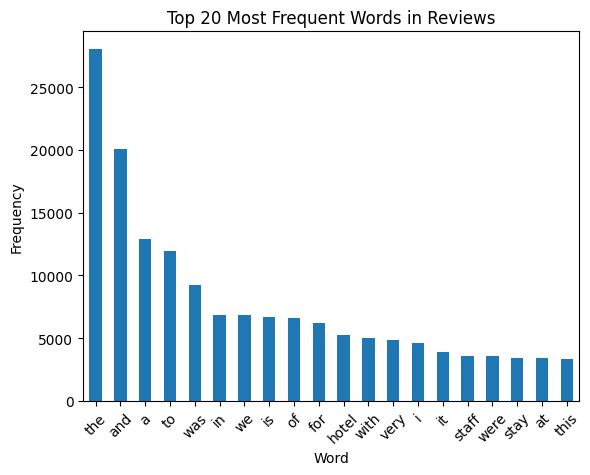

In [23]:
word_counts = reviews["review"].str.split().explode().value_counts()
word_counts.head(20).plot(kind='bar')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Reviews")
plt.xticks(rotation=45)
plt.show()

Here we run into a problem. The most frequent words in the reviews are common stopwords such as "the", "and", "to", etc. These words do not provide much information about the content of the reviews and can be considered noise in our analysis.
To address this, we can remove stopwords from the reviews.

In [24]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])
reviews["review"] = reviews["review"].apply(remove_stopwords)
reviews["review"].head(10)

0    good stay found lighters toilet paper rolls no...
1    definitely recommend hotel excellent food good...
2    wonderful stay comfortable staycooperative sta...
3    favorite 4 star hotel colombo live new york ar...
4    excellent food stay excellent food especially ...
5    outstanding spotless immaculate premises room ...
6    like house keeping also respition good nice li...
7    everything wonderful everything amazing breakf...
8    great experience last week family great experi...
9    good highly recommend accommodating staff love...
Name: review, dtype: object

In [25]:
reviews["review"].str.split().str.len().sum()

263408

After removing stopwords, we can see that the total number of words in the dataset has decreased significantly.

In [26]:
reviews["review"].str.split().explode().nunique()

17998

However, the number of unique words in the corpus has not changed significantly.

We can now once again visualize the top 20 most frequent words in the reviews after removing stopwords.

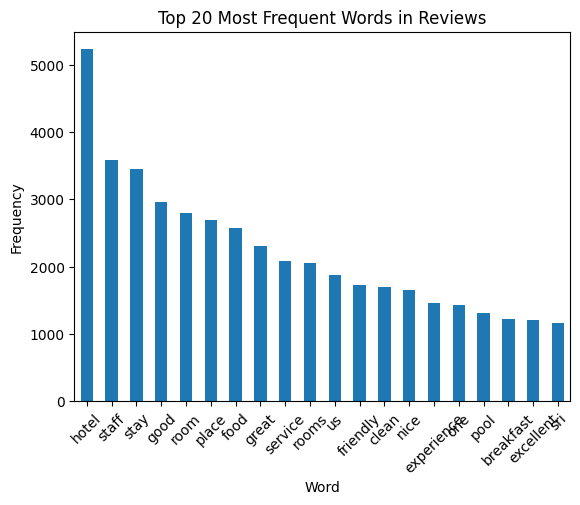

In [27]:
word_counts = reviews["review"].str.split().explode().value_counts()
word_counts.head(20).plot(kind='bar')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Reviews")
plt.xticks(rotation=45)
plt.show()

Now, we can see that the most frequent words in the reviews are more meaningful and provide more information about the content of the reviews.

We can also check the most common bi-grams and tri-grams in the reviews to understand the common phrases used in the reviews.

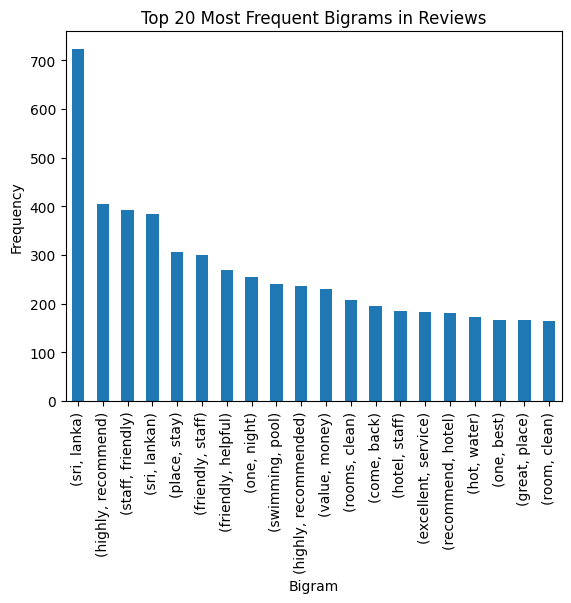

In [28]:
def get_ngrams(text, n):
    words = word_tokenize(text)
    return list(ngrams(words, n))

bigrams = reviews["review"].apply(lambda x: get_ngrams(x, 2)).explode().value_counts()
bigrams.head(20).plot(kind='bar')
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Bigrams in Reviews")
plt.xticks(rotation=90)
plt.show()

Here we can see some clear terms that is related to the reviews.

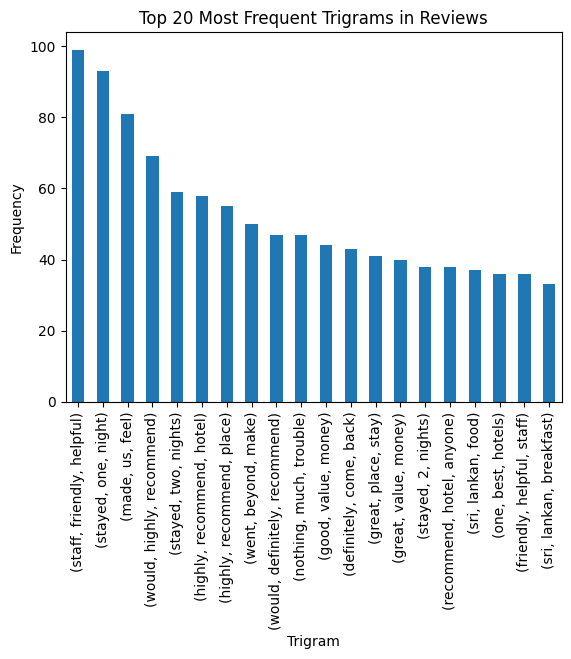

In [29]:
trigrams = reviews["review"].apply(lambda x: get_ngrams(x, 3)).explode().value_counts()
trigrams.head(20).plot(kind='bar')
plt.xlabel("Trigram")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Trigrams in Reviews")
plt.xticks(rotation=90)
plt.show()

Again we see some common terms we would expect to see in a review. These phrases can provide more context and meaning to the reviews, and can be useful for further analysis.

Now we can keep only the columns which are relevant for our analysis.

In [30]:
reviews = reviews[["review_id", "location_id", "hotel_name", "city", "review", "rating"]]
reviews.head()

,review_id,location_id,hotel_name,city,review,rating
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5


Finally, we save this cleaned dataset to a new CSV file for further analysis.

In [31]:
reviews.to_csv("cleaned_reviews.csv", index=False)

## Task 2 - Establishing Ground Truth

First we load the cleaned reviews dataset from task 1.

In [32]:
reviews = pd.read_csv("cleaned_reviews.csv")
reviews.head()

,review_id,location_id,hotel_name,city,review,rating
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5


### Task 2.1. Using TextBlob

We can use TextBlob to analyze the sentiment of the reviews.

In [33]:
reviews['text_blob_sentiment'] = reviews['review'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [34]:
reviews['text_blob_sentiment'].describe()

count    5186.000000
mean        0.367365
std         0.230712
min        -0.825000
25%         0.265239
50%         0.405107
75%         0.514089
max         1.000000
Name: text_blob_sentiment, dtype: float64

When we look at a summary of the sentiment scores, we can see that they range from -1 to 1, where -1 is very negative and 1 is very positive. The mean value is 0.367, indicating a generally positive sentiment across the reviews. The standard deviation is 0.231.

In [35]:
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,0.333333
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,0.470238
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,0.386667
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,0.279339
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,0.519048


Here, we can see that the sentiment scores are continuous values. To convert these into binary sentiment labels, we can use a threshold of 0, where scores above 0 are considered positive and scores below or equal to 0 are considered negative.

In [36]:
reviews['text_blob_sentiment'] = reviews['text_blob_sentiment'].apply(lambda x: 1 if x > 0 else -1)
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1


We can check whether the sentiment analysis is correct by looking at some 5-star and some 1-start reviews.

In [37]:
five_star_reviews = reviews[reviews['rating'] == 5]
five_star_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1
5,1015273964,11953119,Nh Collection Colombo,Colombo,outstanding spotless immaculate premises room ...,5,1


In [38]:
one_star_reviews = reviews[reviews['rating'] == 1]
one_star_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1
22,1013561310,11953119,Nh Collection Colombo,Colombo,dont complaint restaurant food cold otherwise ...,1,-1
76,568472844,11899031,De Colombo Boutique Hotel,Colombo,filthy towers probably worst hotel ive stayed ...,1,-1
77,568472643,11899031,De Colombo Boutique Hotel,Colombo,stay peril total disappointing start holiday s...,1,-1
80,565729487,11899031,De Colombo Boutique Hotel,Colombo,absolutely disgusting stay bug infested overpr...,1,-1


Here, we can see that the TextBlob sentiment analysis is generally correct, as the 5-star reviews have a positive sentiment score and the 1-star reviews have a negative sentiment score. 

However, there is a single 1-star review that has a positive sentiment score.

### Task 2.2. Using VADER

Now, we can use VADER (Valence Aware Dictionary and sEntiment Reasoner) to analyze the sentiment of the reviews. VADER is particularly effective for social media texts and short reviews.

In [39]:
sentiment = SentimentIntensityAnalyzer()
reviews['vader_sentiment'] = reviews['review'].apply(lambda text: sentiment.polarity_scores(text))

In [40]:
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,"{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp..."
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,"{'neg': 0.0, 'neu': 0.316, 'pos': 0.684, 'comp..."
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,"{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp..."
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,"{'neg': 0.0, 'neu': 0.716, 'pos': 0.284, 'comp..."
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,"{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'comp..."


Here, we are given a dictionary with four keys: 'neg', 'neu', 'pos', and 'compound'. The 'compound' score is a normalized score that ranges from -1 (most negative) to +1 (most positive). We will use this score for our binary sentiment classification.

In [41]:
reviews["vader_sentiment"] = reviews["vader_sentiment"].apply(lambda x: x["compound"])
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,0.4404
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,0.9666
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,0.8720
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,0.9493
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,0.9451


In [42]:
reviews["vader_sentiment"].describe()

count    5186.000000
mean        0.811598
std         0.450619
min        -0.994600
25%         0.925750
50%         0.969800
75%         0.985500
max         0.999300
Name: vader_sentiment, dtype: float64

Here, we can see that the average sentiment is 0.812, indicating a generally positive sentiment across the reviews. The standard deviation is 0.451, suggesting some variability in the sentiment scores.

We can once again convert these continuous sentiment scores into binary labels using a threshold of 0, where scores above 0 are considered positive and scores below or equal to 0 are considered negative.

In [43]:
reviews['vader_sentiment'] = reviews['vader_sentiment'].apply(lambda x: 1 if x > 0 else -1)
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1


And then check some 5-star and 1-star reviews to see if the sentiment analysis is correct.

In [44]:
five_star_reviews = reviews[reviews['rating'] == 5]
five_star_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1
5,1015273964,11953119,Nh Collection Colombo,Colombo,outstanding spotless immaculate premises room ...,5,1,1


In [45]:
one_star_reviews = reviews[reviews['rating'] == 1]
one_star_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1
22,1013561310,11953119,Nh Collection Colombo,Colombo,dont complaint restaurant food cold otherwise ...,1,-1,-1
76,568472844,11899031,De Colombo Boutique Hotel,Colombo,filthy towers probably worst hotel ive stayed ...,1,-1,-1
77,568472643,11899031,De Colombo Boutique Hotel,Colombo,stay peril total disappointing start holiday s...,1,-1,-1
80,565729487,11899031,De Colombo Boutique Hotel,Colombo,absolutely disgusting stay bug infested overpr...,1,-1,-1


Similar to TextBlob, the VADER sentiment analysis is generally correct, as the 5-star reviews have a positive sentiment score and the 1-star reviews have a negative sentiment score.

But once again, there is a single 1-star review that has a positive sentiment score.

### Task 2.3. Using Transformers

Since our transformer model has a maximum input length of 512 tokens, we need to limit the length of the reviews to this maximum length.

In [46]:
def limit_tokens(text, max_length=512):
    return text[:max_length]

reviews['transformer_review'] = reviews['review'].apply(limit_tokens)

Now, we can use a pre-trained transformer model for sentiment analysis.

This provides two outputs, `score` and `label`, where `score` is the confidence score of the sentiment label and `label` is either 'POSITIVE' or 'NEGATIVE'.

In [48]:
sentiment_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
reviews['transformer_sentiment'] = reviews['transformer_review'].apply(lambda text: sentiment_classifier(text)[0])

reviews['transformer_sentiment_score'] = reviews['transformer_sentiment'].apply(lambda x: x['score'])
reviews['transformer_sentiment_label'] = reviews['transformer_sentiment'].apply(lambda x: x['label'])
reviews.head()

Device set to use cpu


,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment,transformer_review,transformer_sentiment,transformer_sentiment_score,transformer_sentiment_label
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1,good stay found lighters toilet paper rolls no...,"{'label': 'POSITIVE', 'score': 0.9806791543960...",0.980679,POSITIVE
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1,definitely recommend hotel excellent food good...,"{'label': 'POSITIVE', 'score': 0.999824583530426}",0.999825,POSITIVE
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1,wonderful stay comfortable staycooperative sta...,"{'label': 'POSITIVE', 'score': 0.9993433356285...",0.999343,POSITIVE
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1,favorite 4 star hotel colombo live new york ar...,"{'label': 'POSITIVE', 'score': 0.9975016713142...",0.997502,POSITIVE
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1,excellent food stay excellent food especially ...,"{'label': 'POSITIVE', 'score': 0.9997791647911...",0.999779,POSITIVE


We can calculate an overall sentiment score by multiplying the score by -1 if the label is 'NEGATIVE', and leaving it as is if the label is 'POSITIVE'. This way, we can convert the sentiment scores into a binary format where positive sentiment is represented by 1 and negative sentiment by -1.

In [49]:
reviews['transformer_sentiment'] = reviews.apply(
    lambda row: row['transformer_sentiment_score'] * -1 if row['transformer_sentiment_label'] == 'NEGATIVE' else row['transformer_sentiment_score'],
    axis=1
)
reviews = reviews.drop(columns=["transformer_review", "transformer_sentiment_score", "transformer_sentiment_label"])
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment,transformer_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1,0.980679
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1,0.999825
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1,0.999343
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1,0.997502
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1,0.999779


In [50]:
reviews['transformer_sentiment'].describe()

count    5186.000000
mean        0.623263
std         0.763787
min        -0.999799
25%         0.982515
50%         0.999153
75%         0.999708
max         0.999882
Name: transformer_sentiment, dtype: float64

Here, we can see that the average sentiment is 0.623, indicating a generally positive sentiment across the reviews. The standard deviation is 0.764.

Once again, we can convert these continuous sentiment scores into binary labels using a threshold of 0, where scores above 0 are considered positive and scores below or equal to 0 are considered negative.

In [51]:
reviews['transformer_sentiment'] = reviews['transformer_sentiment'].apply(lambda x: 1 if x > 0 else -1)
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment,transformer_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1,1


And then check some 5-star and 1-star reviews to see if the sentiment analysis is correct.

In [52]:
five_star_reviews = reviews[reviews['rating'] == 5]
five_star_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment,transformer_sentiment
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1,1
5,1015273964,11953119,Nh Collection Colombo,Colombo,outstanding spotless immaculate premises room ...,5,1,1,1


In [53]:
one_star_reviews = reviews[reviews['rating'] == 1]
one_star_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment,transformer_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1,1
22,1013561310,11953119,Nh Collection Colombo,Colombo,dont complaint restaurant food cold otherwise ...,1,-1,-1,-1
76,568472844,11899031,De Colombo Boutique Hotel,Colombo,filthy towers probably worst hotel ive stayed ...,1,-1,-1,-1
77,568472643,11899031,De Colombo Boutique Hotel,Colombo,stay peril total disappointing start holiday s...,1,-1,-1,-1
80,565729487,11899031,De Colombo Boutique Hotel,Colombo,absolutely disgusting stay bug infested overpr...,1,-1,-1,-1


Similar to TextBlob and VADER, the transformer sentiment analysis is generally correct, as the 5-star reviews have a positive sentiment score and the 1-star reviews have a negative sentiment score.

Once again, there is a single 1-star review that has a positive sentiment score.

### Task 2.4. Establishing Ground Truth with Majority Voting

Here, we simply use majority voting to establish the ground truth sentiment for each review. We will consider the sentiment labels from TextBlob, VADER, and the transformer model.

In [54]:
# majority voting to establish ground truth
def majority_vote(row):
    votes = [row['text_blob_sentiment'], row['vader_sentiment'], row['transformer_sentiment']]
    return max(set(votes), key=votes.count)

reviews['ground_truth_sentiment'] = reviews.apply(majority_vote, axis=1)
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,text_blob_sentiment,vader_sentiment,transformer_sentiment,ground_truth_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1,1,1,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1,1,1,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1,1,1,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1,1,1,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1,1,1,1


Finally, we remove the unnecessary columns and save the reviews with the ground truth sentiment to a new CSV file.

In [55]:
reviews = reviews[["review_id", "location_id", "hotel_name", "city", "review", "rating", "ground_truth_sentiment"]]
reviews.to_csv("ground_truth_reviews.csv", index=False)

## Task 3 - Feature Extraction
First we will load the ground truth reviews dataset.

In [56]:
reviews = pd.read_csv("ground_truth_reviews.csv")
reviews.head()

,review_id,location_id,hotel_name,city,review,rating,ground_truth_sentiment
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,1
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,1
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,1
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,1
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1


### 3.1. Bag of Words (BoW)
Here, we will create a Bag of Words (BoW) representation of the reviews. 
This involves tokenizing the text and creating a matrix where each row corresponds to a review and each column corresponds to a word in the vocabulary.

In [57]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reviews["review"])

In [58]:
vocabulary = vectorizer.get_feature_names_out()
print(f"Size of BoW vocabulary: {len(vocabulary)}")

Size of BoW vocabulary: 17968


We can see here that there are 17,968 unique words in the vocabulary extracted from the reviews.

In [59]:
bow_matrix = pd.DataFrame(X.toarray(), columns=vocabulary)
print(f"Shape of the BoW matrix: {bow_matrix.shape}")

Shape of the BoW matrix: (5186, 17968)


The shape of the BoW matrix is (5186, 17968), meaning there are 5186 reviews, and each vector has 17968 features corresponding to the unique words in the vocabulary.

We can even print the first row of the BoW matrix to see how it looks.

In [60]:
print(bow_matrix.iloc[0])

000                   0
01                    0
0111and               0
0120                  0
0130                  0
                     ..
顶楼还有个游泳池不过没来得及享受一下    0
𝐄𝐚𝐬𝐡𝐚𝐧𝐢               0
𝐆𝐮𝐞𝐬𝐭                 0
𝐑𝐞𝐥𝐚𝐭𝐢𝐨𝐧𝐬             0
𝐢𝐧                    0
Name: 0, Length: 17968, dtype: int64


Let's check for some words from the first review that are present.

In [61]:
print(bow_matrix.iloc[0][bow_matrix.iloc[0] > 0])

beds        1
booked      1
even        1
found       1
give        1
good        1
lighters    1
non         1
paper       1
rolls       1
room        1
smoking     1
stay        1
though      1
toilet      1
twin        1
us          1
Name: 0, dtype: int64


### 3.2. Term Frequency-Inverse Document Frequency (TF-IDF)
Here, we will create a Term Frequency-Inverse Document Frequency (TF-IDF) representation of the reviews.

In [62]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews['review'])

In [63]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Size of TF-IDF vocabulary: {len(feature_names)}")

Size of TF-IDF vocabulary: 17968


Once again, we can see that there are 17,968 unique words in the vocabulary extracted from the reviews.

In [64]:
tfidf_matrix_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(f"Shape of the TF-IDF matrix: {tfidf_matrix_df.shape}")

Shape of the TF-IDF matrix: (5186, 17968)


The shape of the TF-IDF matrix is also (5186, 17968), meaning there are 5186 reviews, and each vector has 17968 features corresponding to the unique words in the vocabulary.

Once again, we can print the first row of the TF-IDF matrix to see how it looks.

In [65]:
print(tfidf_matrix_df.iloc[0])

000                   0.0
01                    0.0
0111and               0.0
0120                  0.0
0130                  0.0
                     ... 
顶楼还有个游泳池不过没来得及享受一下    0.0
𝐄𝐚𝐬𝐡𝐚𝐧𝐢               0.0
𝐆𝐮𝐞𝐬𝐭                 0.0
𝐑𝐞𝐥𝐚𝐭𝐢𝐨𝐧𝐬             0.0
𝐢𝐧                    0.0
Name: 0, Length: 17968, dtype: float64


Let's check for some words from the first review that are present in the TF-IDF matrix.

In [66]:
print(tfidf_matrix_df.iloc[0][tfidf_matrix_df.iloc[0] > 0])

beds        0.203157
booked      0.181399
even        0.144703
found       0.203431
give        0.205972
good        0.092402
lighters    0.406354
non         0.280659
paper       0.296387
rolls       0.342779
room        0.095741
smoking     0.374567
stay        0.084388
though      0.192924
toilet      0.232811
twin        0.320513
us          0.112083
Name: 0, dtype: float64


We can also check for the top 10 words with the highest TF-IDF scores in the first review.

In [67]:
top_tfidf_words = tfidf_matrix_df.iloc[0].nlargest(10)
print("Top 10 words with highest TF-IDF scores in the first review:")
print(top_tfidf_words)

Top 10 words with highest TF-IDF scores in the first review:
lighters    0.406354
smoking     0.374567
rolls       0.342779
twin        0.320513
paper       0.296387
non         0.280659
toilet      0.232811
give        0.205972
found       0.203431
beds        0.203157
Name: 0, dtype: float64


### 3.3. Word2Vec
Here, we will create a Word2Vec model using the reviews.

First, we need to tokenize the reviews into words.

In [68]:
tokenized_reviews = [word_tokenize(review.lower()) for review in reviews['review']]

Now we can train a Word2Vec model on the tokenized reviews. We will use a vector size of 500, a window size of 100, and set the minimum count to 0 to include all words.

In [69]:
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=500, window=100, min_count=0, workers=8, sg=1)
w2v_model.save("word2vec.model")

In [70]:
print(f"Shape of the Word2Vec matrix: {w2v_model.wv.vectors.shape}")

Shape of the Word2Vec matrix: (17998, 500)


We can see that the Word2Vec model has a shape of (17998, 500), meaning there are 17,998 unique words in the vocabulary, and each word is represented by a 500-dimensional vector.

We can also check the vector value for a specific word, such as "bed".

In [71]:
bed_vector = w2v_model.wv['bed']
print(f"Vector for 'bed': {bed_vector}")

Vector for 'bed': [ 0.1844372  -0.10257292  0.17788999  0.19952342  0.04292466 -0.23675644
  0.07076817  0.03539717  0.08850911 -0.02314061 -0.05752808  0.03549338
  0.00104585  0.01297401 -0.10800468 -0.25414315  0.05870118 -0.07489647
 -0.05281977  0.22001526 -0.02574226 -0.04577768  0.17006585 -0.21410057
  0.10951288 -0.00938682 -0.00614369  0.04501679 -0.34815875  0.03551801
  0.20308386 -0.08911312 -0.00210324  0.03012024  0.02330348  0.06697601
  0.02439669 -0.0392347  -0.05458113  0.05747749  0.10461799 -0.10335528
 -0.06747732  0.23971984 -0.11673975 -0.1081759  -0.05466682  0.13536918
 -0.0706562  -0.03587937 -0.0635895  -0.10628379 -0.05294625 -0.21889162
  0.07317803 -0.04108338  0.08783511  0.03113046 -0.077149   -0.18124133
  0.22803335  0.03314252  0.03984741 -0.11962193 -0.01882334 -0.17456776
  0.00993659  0.0074919  -0.00315017  0.05624627 -0.06785657 -0.2537139
 -0.04047243  0.19330123 -0.09077385 -0.00248228  0.08260996 -0.05269075
  0.21162105  0.12569617 -0.070866

We can also find the most similar words to "bed" using the Word2Vec model.

In [72]:
similar_words = w2v_model.wv.most_similar('bed')
print(f"Most similar words to 'bed': {similar_words}")

Most similar words to 'bed': [('squeezed', 0.6514195799827576), ('partially', 0.6497069597244263), ('duvets', 0.6381158828735352), ('airconditioner', 0.6350743770599365), ('dressing', 0.6348100304603577), ('ragged', 0.6344547867774963), ('doubles', 0.6331870555877686), ('bathroom', 0.6308902502059937), ('deet', 0.6283610463142395), ('drenching', 0.6272135376930237)]


We can also perform analogy tasks using the Word2Vec model. For example, we can find a word that is to "colombo" as "galle" is to "city".

In [73]:
analogy_result = w2v_model.wv.most_similar(positive=['colombo', 'galle'], negative=['city'], topn=1)
print(f"Analogy result for 'colombo' - 'city' + 'galle': {analogy_result}")

Analogy result for 'colombo' - 'city' + 'galle': [('fort', 0.4800596237182617)]


Here, we can see that the model determines that Colombo - City + Galle = Fort. Which makes intuitive sense. 

We can also perform other analogy tasks, such as finding a word that is to "bed" as "internet" is to "sleep".

In [74]:
analogy_result = w2v_model.wv.most_similar(positive=['bed', 'internet'], negative=['sleep'], topn=1)
print(f"Analogy result for 'bed' - 'sleep' + 'internet': {analogy_result}")

Analogy result for 'bed' - 'sleep' + 'internet': [('cons', 0.5540193319320679)]


Here, it determined that Bed - Sleep + Internet = Connection. Which also makes sense.

Let's check another analogy task, such as finding a word that is to "bed" as "water" is to "pillow".

In [75]:
analogy_result = w2v_model.wv.most_similar(positive=['bed', 'water'], negative=['pillow'], topn=1)
print(f"Analogy result for 'bed' - 'pillow' + 'water': {analogy_result}")

Analogy result for 'bed' - 'pillow' + 'water': [('hot', 0.46690458059310913)]


Here, it determined that Bed - Pillow + Water = Hot. This is unexpected, and highlights the limitations of the model in understanding certain relationships.

We can also check for some common relationships, but those which might not be present in the dataset.

In [76]:
result = w2v_model.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print(f"Analogy result for 'king' - 'man' + 'woman': {result}")

Analogy result for 'king' - 'man' + 'woman': [('anjalee', 0.6017975211143494)]


Here, we see that the model struggles to come up with a meaningful analogy for this relationship, which highlights the limitations of the dataset to generalize.

Finally, we can vectorize the reviews using the Word2Vec model by averaging the word vectors for each review.

In [77]:
def get_review_vector(review, model):
    tokens = word_tokenize(review.lower())
    vector = sum(model.wv[token] for token in tokens if token in model.wv) / len(tokens)
    return vector

w2v_review_vectors = reviews['review'].apply(lambda x: get_review_vector(x, w2v_model))
w2v_review_vectors = np.vstack(w2v_review_vectors.values)
w2v_review_vectors = pd.DataFrame(w2v_review_vectors)
print(f"Shape of the Word2Vec review vectors: {w2v_review_vectors.shape}")

Shape of the Word2Vec review vectors: (5186, 500)


We can see that the dataset now consists of 5186 reviews, and each review is represented by a 500-dimensional vector. We can even print the first review vector to see how it looks.

In [78]:
print(w2v_review_vectors[0])

0       0.027821
1      -0.012155
2       0.006719
3       0.050971
4       0.013252
          ...   
5181    0.037094
5182    0.023887
5183    0.002189
5184    0.010953
5185   -0.018435
Name: 0, Length: 5186, dtype: float32


### 3.4. Doc2Vec

In [79]:
tokenized_reviews = [word_tokenize(review.lower()) for review in reviews['review']]
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_reviews)]

doc2vec_model = Doc2Vec(vector_size=500, window=50, min_count=1, workers=8, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

doc2vec_review_vectors = np.vstack([doc2vec_model.infer_vector(words) for words in tokenized_reviews])
doc2vec_review_vectors = pd.DataFrame(doc2vec_review_vectors)

In [80]:
print(f"Shape of the Doc2Vec review vectors: {doc2vec_review_vectors.shape}")

Shape of the Doc2Vec review vectors: (5186, 500)


In [81]:
inferred_vector = doc2vec_model.infer_vector("the bed was uncomfortable".lower().split())
print(inferred_vector.shape)

(500,)


In [82]:
print(inferred_vector)

[ 8.14211834e-03  1.31451143e-02  3.59016210e-02  2.35563572e-02
 -1.72582902e-02 -1.78530458e-02  1.12911575e-02  2.36368217e-02
  4.73257998e-04 -3.00145242e-03 -4.35618870e-03 -7.57505465e-03
  1.90240648e-02 -8.55872594e-03  1.38425007e-02 -6.38915822e-02
 -1.95247047e-02 -3.06914952e-02 -1.01258615e-02 -6.48445077e-03
  7.89745897e-03 -2.13737171e-02  2.19342373e-02  2.16143578e-03
  9.87065677e-03  1.86061487e-02  4.81344759e-03 -2.83058663e-03
 -4.70013842e-02 -3.01680826e-02  1.72006823e-02 -7.06574321e-03
  1.75223816e-02 -1.38048949e-02  2.22008731e-02  4.99573629e-03
  1.47084659e-02 -4.80641946e-02 -1.85609162e-02 -3.38403843e-02
 -2.26015914e-02 -9.47795343e-03 -1.34116355e-02  8.63720663e-03
 -6.85438141e-03 -2.45347377e-02  5.83647052e-03  1.72961671e-02
 -1.59516546e-03  2.50510871e-03 -2.46076882e-02  3.00840964e-03
  5.04804915e-03 -1.28899524e-02 -6.08506566e-03 -2.20296113e-03
  1.70543627e-03 -1.04843322e-02  2.08804794e-02  4.35620593e-03
 -1.08019740e-03 -1.19080

In [83]:
similar_docs = doc2vec_model.dv.most_similar([inferred_vector], topn=5)

for doc_id, similarity in similar_docs:
    print(f"Document {doc_id}: Similarity={similarity:.4f}")
    print("Review:", reviews['review'].iloc[int(doc_id)])
    print("---")

Document 1494: Similarity=0.8206
Review: interesting hotel staff made feel incredibly welcome room spotless wellappointed highlight stay food every meal culinary delight dishes beautifully presented also bursting flavor breakfast buffet particularly impressive offering wide variety options freshly prepared dining onsite restaurant true pleasure menu catered tastes whether breakfast lunch dinner every meal exceeded expectations hotel mustvisit food lover looking luxurious stay
---
Document 2614: Similarity=0.8160
Review: beautiful hotel really enyoyed staying beautifull hotel room veary clean air con host frendly arranged us tour really nice tuctuc driver tharindu took us see waterfalls came back got us fresh juice dinner breakfast delicius
---
Document 947: Similarity=0.8104
Review: perfect place stay pleasant stay senani hotel clean rooms good food helpful staff meals amantha made sure everything thank much definitely come back hotel future
---
Document 2784: Similarity=0.8082
Review:

Finally, we can save all the feature matrices to CSV files for further use.

In [84]:
feature_matrices = {
    'bow': bow_matrix,
    'tfidf': tfidf_matrix_df,
    'word2vec': w2v_review_vectors,
    'doc2vec': doc2vec_review_vectors
}

In [85]:
for name, matrix in feature_matrices.items():
    print(f"Saving {name} feature matrix...")
    matrix.to_csv(f"feature_matrix_{name}.csv", index=False)

Saving bow feature matrix...
Saving tfidf feature matrix...
Saving word2vec feature matrix...
Saving doc2vec feature matrix...


## Task 4 - Text Classification

First we load the feature matrices and the ground truth sentiment labels that we compiled in task 3.

In [86]:
bow_data = pd.read_csv('feature_matrix_bow.csv')
tfidf_data = pd.read_csv('feature_matrix_tfidf.csv')
word2vec_data = pd.read_csv('feature_matrix_word2vec.csv')
doc2vec_data = pd.read_csv('feature_matrix_doc2vec.csv')

In [87]:
reviews = pd.read_csv('ground_truth_reviews.csv')
ground_truth = reviews['ground_truth_sentiment'].values

Now we define a function, that can apply a classifier to the feature matrix and the ground truth labels, and print out the accuracy, precision, recall, F1 score and confusion matrix.

In [88]:
def classifier(features, ground_truth, name, clf):    
    y_pred = cross_val_predict(clf, features, ground_truth, cv=5)    
    print(f'Accuracy for {name}: {accuracy_score(ground_truth, y_pred):.4f}')
    print(f"Precision for {name}: {precision_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"Recall for {name}: {recall_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"F1 Score for {name}: {f1_score(ground_truth, y_pred, average='weighted'):.4f}")
    
    cm = confusion_matrix(ground_truth, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(text_kw={'color': 'black'})
    plt.title(f'Confusion Matrix on {name} Features')
    plt.show()
    
    return f1_score(ground_truth, y_pred, average='weighted')

We also create a dictionary to store the F1 scores for each classifier and feature matrix combination for later comparison.

In [89]:
f1_scores = {
    "naive_bayes": {
        "bow": 0.0,
        "tfidf": 0.0,
        "word2vec": 0.0,
        "doc2vec": 0.0
    },
    "svm": {
        "bow": 0.0,
        "tfidf": 0.0,
        "word2vec": 0.0,
        "doc2vec": 0.0
    },
    "random_forest": {
        "bow": 0.0,
        "tfidf": 0.0,
        "word2vec": 0.0,
        "doc2vec": 0.0
    }
}

### 4.1. Naive Bayes Classifier
We first try using the Naive Bayes classifier on the different feature matrices. 

We selected the Naive Bayes classifier because it is simple, fast, and often effective for text classification tasks.

We use `MultinomialNB` for Bag of Words, TF-IDF, and Word2Vec. And we use `GaussianNB` for GloVe.

Accuracy for Bag of Words: 0.9580
Precision for Bag of Words: 0.9612
Recall for Bag of Words: 0.9580
F1 Score for Bag of Words: 0.9592


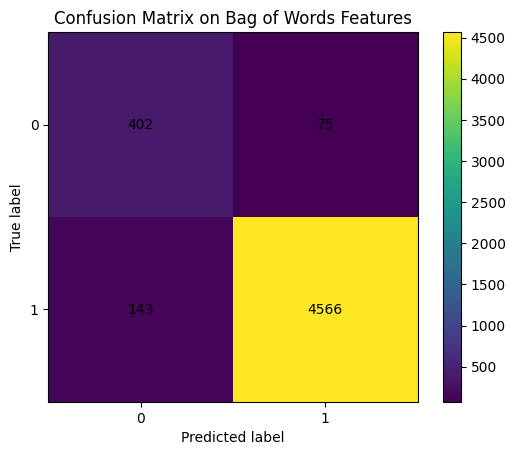

In [90]:
f1_scores["naive_bayes"]["bow"] = classifier(bow_data, ground_truth, "Bag of Words", MultinomialNB())

Accuracy for TF-IDF: 0.9321
Precision for TF-IDF: 0.9319
Recall for TF-IDF: 0.9321
F1 Score for TF-IDF: 0.9320


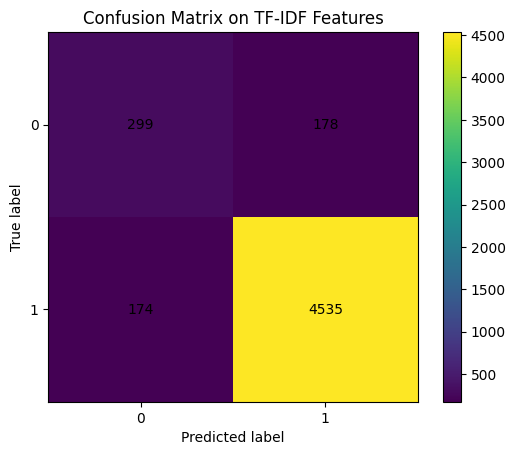

In [91]:
f1_scores["naive_bayes"]["tfidf"] = classifier(MinMaxScaler().fit_transform(tfidf_data), ground_truth, "TF-IDF", MultinomialNB())

Accuracy for Word2Vec: 0.9472
Precision for Word2Vec: 0.9597
Recall for Word2Vec: 0.9472
F1 Score for Word2Vec: 0.9510


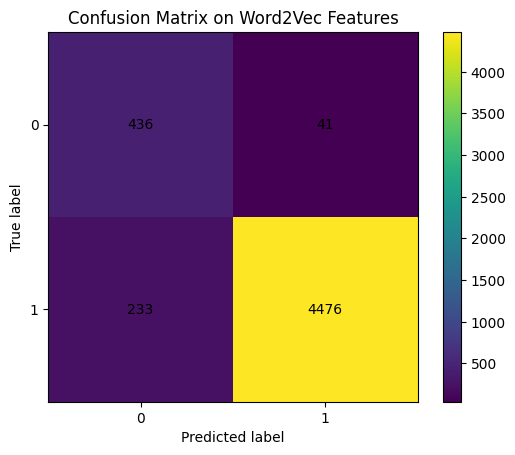

In [92]:
f1_scores["naive_bayes"]["word2vec"] = classifier(MinMaxScaler().fit_transform(word2vec_data), ground_truth, "Word2Vec", MultinomialNB())

Accuracy for Doc2Vec: 0.9080
Precision for Doc2Vec: 0.8706
Recall for Doc2Vec: 0.9080
F1 Score for Doc2Vec: 0.8646


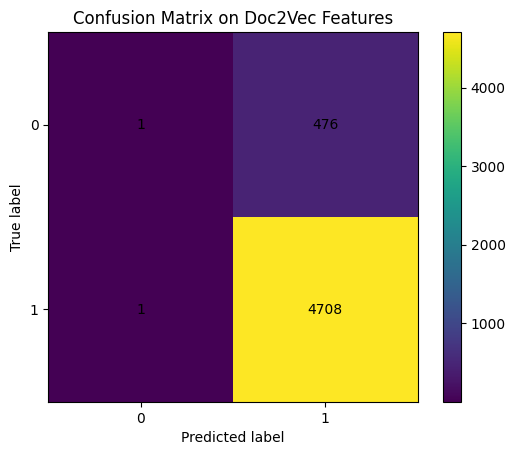

In [93]:
f1_scores["naive_bayes"]["doc2vec"] = classifier(MinMaxScaler().fit_transform(doc2vec_data), ground_truth, "Doc2Vec", MultinomialNB())

### 4.2. Support Vector Machine Classifier
Next, we apply the Support Vector Machine (SVM) classifier to the feature matrices.


We use `SVC` with a linear kernel, which is often effective for text classification tasks.

Accuracy for Bag of Words: 0.9620
Precision for Bag of Words: 0.9610
Recall for Bag of Words: 0.9620
F1 Score for Bag of Words: 0.9614


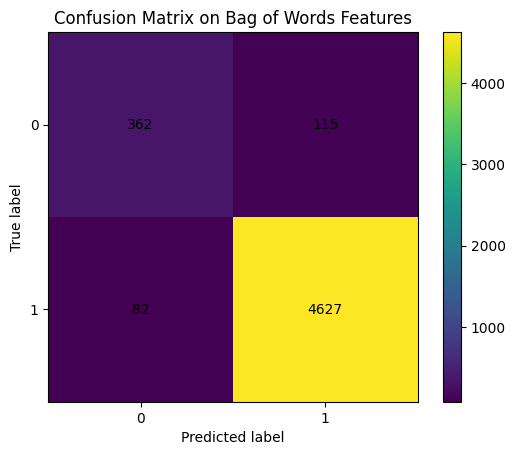

In [94]:
f1_scores["svm"]["bow"] = classifier(bow_data, ground_truth, "Bag of Words", SVC(kernel='linear'))

Accuracy for TF-IDF: 0.9636
Precision for TF-IDF: 0.9618
Recall for TF-IDF: 0.9636
F1 Score for TF-IDF: 0.9617


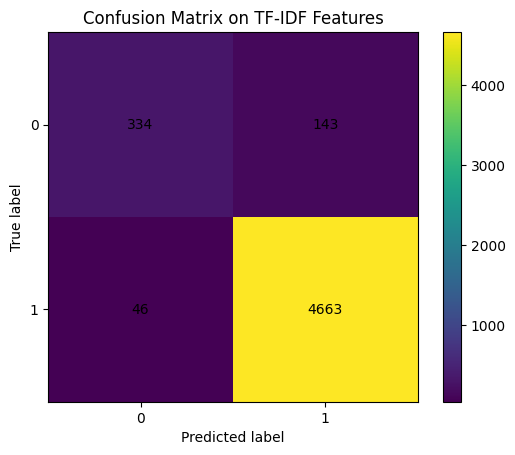

In [95]:
f1_scores["svm"]["tfidf"] = classifier(tfidf_data, ground_truth, "TF-IDF", SVC(kernel='linear'))

Accuracy for Word2Vec: 0.9693
Precision for Word2Vec: 0.9694
Recall for Word2Vec: 0.9693
F1 Score for Word2Vec: 0.9694


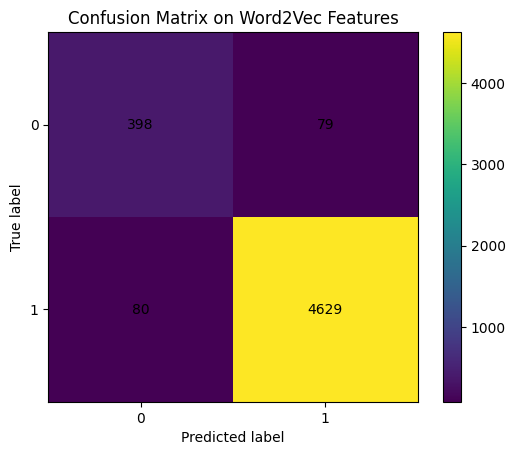

In [96]:
f1_scores["svm"]["word2vec"] = classifier(word2vec_data, ground_truth, "Word2Vec", SVC(kernel='linear'))

Accuracy for Doc2Vec: 0.9207
Precision for Doc2Vec: 0.9071
Recall for Doc2Vec: 0.9207
F1 Score for Doc2Vec: 0.9025


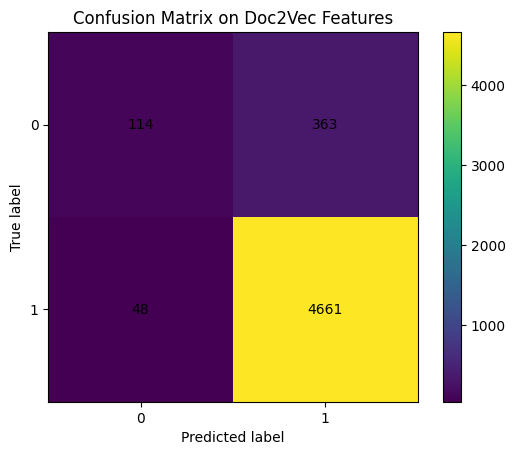

In [97]:
f1_scores["svm"]["doc2vec"] = classifier(doc2vec_data, ground_truth, "Doc2Vec", SVC(kernel='linear'))

### 4.3. Random Forest Classifier

Finally, we apply the Random Forest classifier to the feature matrices.

We use `RandomForestClassifier`, which is an ensemble method that can handle high-dimensional data and is robust to overfitting.

Accuracy for Bag of Words: 0.9429
Precision for Bag of Words: 0.9422
Recall for Bag of Words: 0.9429
F1 Score for Bag of Words: 0.9327


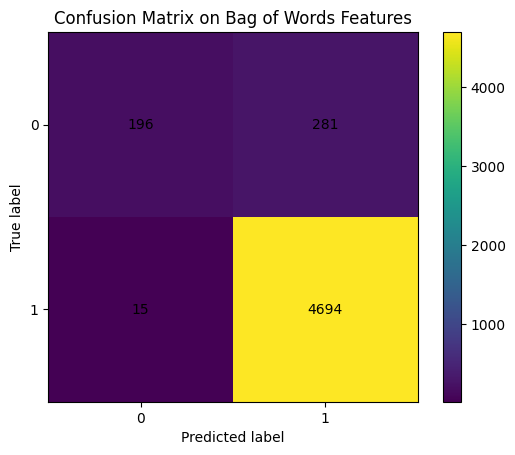

In [98]:
f1_scores["random_forest"]["bow"] = classifier(bow_data, ground_truth, "Bag of Words", RandomForestClassifier())

Accuracy for TF-IDF: 0.9404
Precision for TF-IDF: 0.9423
Recall for TF-IDF: 0.9404
F1 Score for TF-IDF: 0.9277


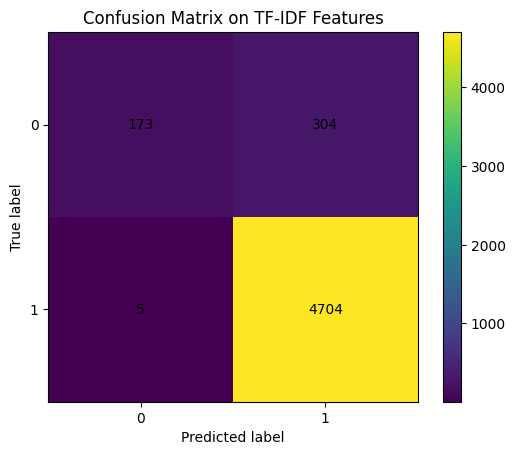

In [99]:
f1_scores["random_forest"]["tfidf"] = classifier(tfidf_data, ground_truth, "TF-IDF", RandomForestClassifier())

Accuracy for Word2Vec: 0.9636
Precision for Word2Vec: 0.9624
Recall for Word2Vec: 0.9636
F1 Score for Word2Vec: 0.9628


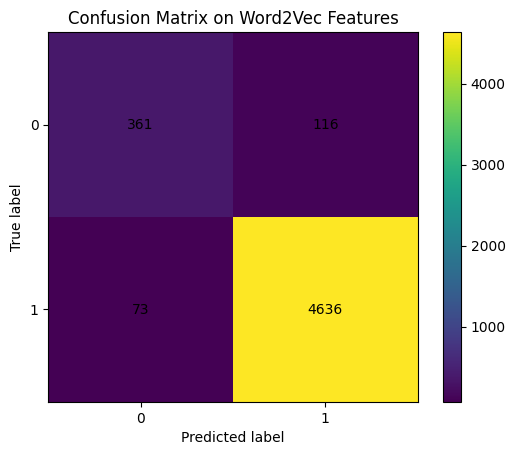

In [100]:
f1_scores["random_forest"]["word2vec"] = classifier(word2vec_data, ground_truth, "Word2Vec", RandomForestClassifier())

Accuracy for Doc2Vec: 0.9111
Precision for Doc2Vec: 0.8918
Recall for Doc2Vec: 0.9111
F1 Score for Doc2Vec: 0.8761


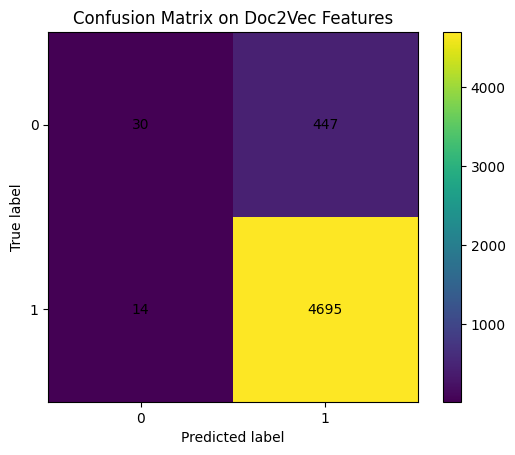

In [101]:
f1_scores["random_forest"]["doc2vec"] = classifier(doc2vec_data, ground_truth, "Doc2Vec", RandomForestClassifier())

Finally, we print out the F1 scores for each classifier and feature matrix combination in a DataFrame for easy comparison.

In [102]:
f1_df = pd.DataFrame(f1_scores)
print(f1_df)

          naive_bayes       svm  random_forest
bow          0.959209  0.961399       0.932673
tfidf        0.931996  0.961679       0.927734
word2vec     0.951042  0.969355       0.962778
doc2vec      0.864625  0.902497       0.876121


From the results, we can see that the SVM classifier with Word2Vec has the highest F1 score.

## Task 5 - Using Pretrained Vectors

First load the ground truth dataset which contains the reviews and their corresponding sentiment labels.

In [103]:
reviews = pd.read_csv('ground_truth_reviews.csv')
ground_truth = reviews['ground_truth_sentiment'].values

### 5.1. Using BERT for Text Embeddings

Here, we choose to go with BERT (Bidirectional Encoder Representations from Transformers) for generating text embeddings. BERT is a powerful transformer-based model that captures the context of words in a sentence.

In [104]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

We can use BERT to generate embeddings for each review. The embeddings will be the output of the [CLS] token, which is designed to capture the overall meaning of the text.

In [105]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

Then we can apply this function to the reviews in our dataset to generate the embeddings.

In [106]:
reviews = pd.read_csv('ground_truth_reviews.csv')
bert_vectors = reviews['review'].apply(get_bert_embedding)
bert_vectors = np.vstack(bert_vectors.values)

In [107]:
print(bert_vectors.shape)

(5186, 768)


Here, we can see that the shape of `bert_vectors` is `(5186, 768)`, where 768 is the dimensionality of the BERT embeddings.

### 5.2. Classifying with BERT Embeddings

Here, similar to task 4, we will use the BERT embeddings to train various classifiers and evaluate their performance. We will use Naive Bayes, SVM, and Random Forest.

In [108]:
def classifier(features, ground_truth, name, clf):
    y_pred = cross_val_predict(clf, features, ground_truth, cv=5)
    print(f'Accuracy for {name}: {accuracy_score(ground_truth, y_pred):.4f}')
    print(f"Precision for {name}: {precision_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"Recall for {name}: {recall_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"F1 Score for {name}: {f1_score(ground_truth, y_pred, average='weighted'):.4f}")

    cm = confusion_matrix(ground_truth, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(text_kw={'color': 'black'})
    plt.title(f'Confusion Matrix for Naive Bayes on {name} Features')
    plt.show()

    return f1_score(ground_truth, y_pred, average='weighted')

Accuracy for Bag of Words: 0.9335
Precision for Bag of Words: 0.9414
Recall for Bag of Words: 0.9335
F1 Score for Bag of Words: 0.9366


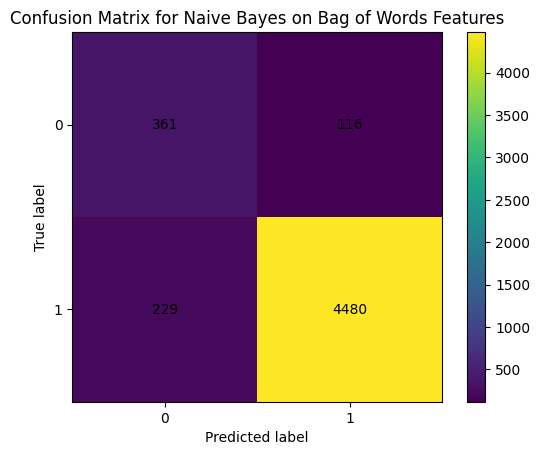

0.9365934570685694

In [109]:
classifier(MinMaxScaler().fit_transform(bert_vectors), ground_truth, "Bag of Words", MultinomialNB())

Accuracy for SVM: 0.9578
Precision for SVM: 0.9554
Recall for SVM: 0.9578
F1 Score for SVM: 0.9550


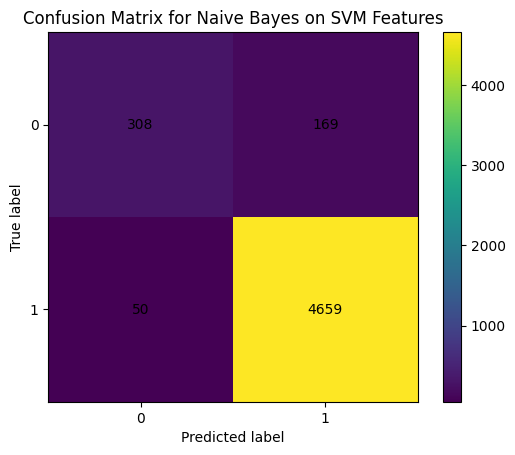

0.9550252450711283

In [110]:
classifier(bert_vectors, ground_truth, "SVM", SVC(kernel='rbf'))

Accuracy for Random Forest: 0.9354
Precision for Random Forest: 0.9308
Recall for Random Forest: 0.9354
F1 Score for Random Forest: 0.9232


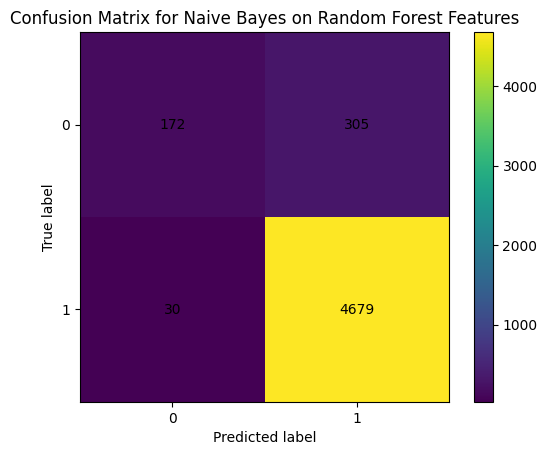

0.9232382196854205

In [111]:
classifier(bert_vectors, ground_truth, "Random Forest", RandomForestClassifier())

We see that the SVM classifier performs the best with an F1 score of 0.955. But we were able to achieve a better performance using Word2Vec and SVM.

### 5.3. Using BERT Embeddings in a Neural Network

Here, we build and train a simple neural network using the BERT embeddings. The architecture consists of two hidden layers with ReLU activation and dropout for regularization. The hyperparameters were tuned to achieve the best performance after several trials.

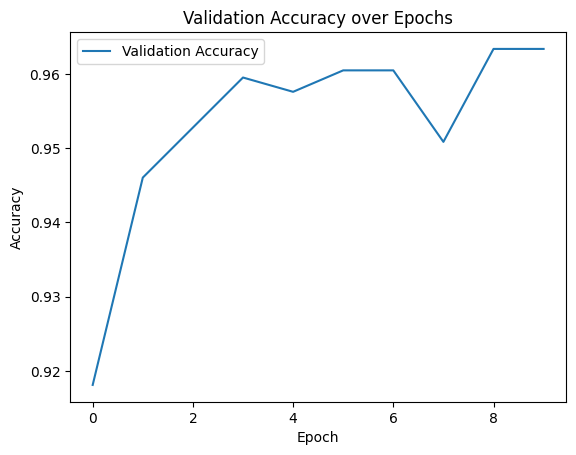

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold: Accuracy=0.9634, Precision=0.9656, Recall=0.9634, F1=0.9643


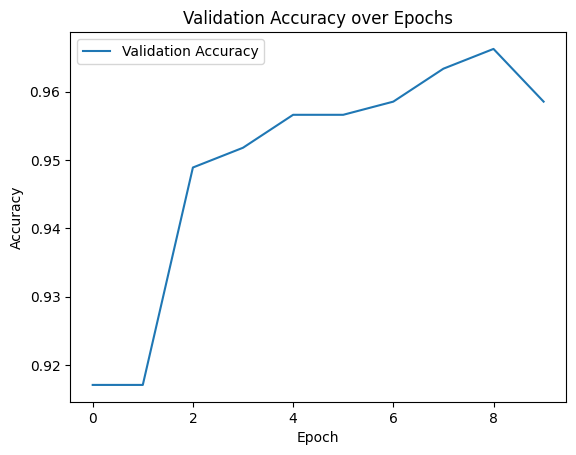

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold: Accuracy=0.9585, Precision=0.9575, Recall=0.9585, F1=0.9580


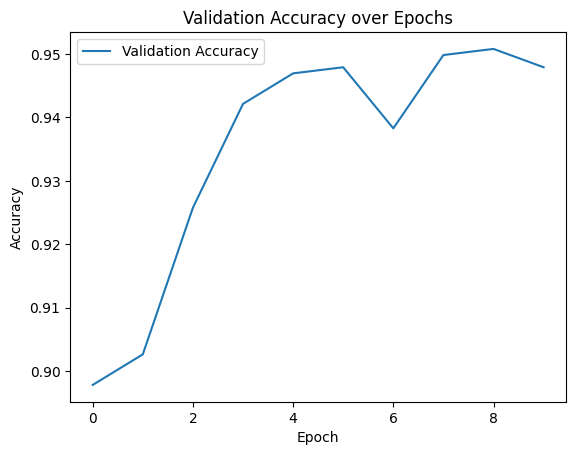

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold: Accuracy=0.9479, Precision=0.9450, Recall=0.9479, F1=0.9456


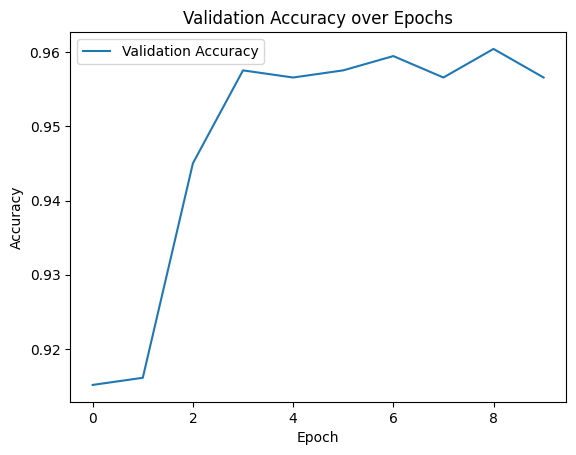

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold: Accuracy=0.9566, Precision=0.9549, Recall=0.9566, F1=0.9556


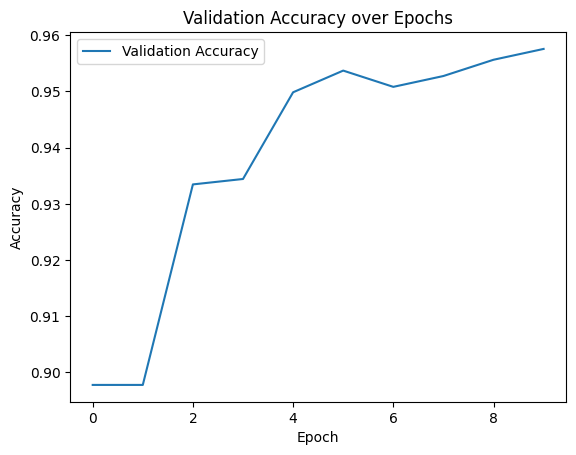

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold: Accuracy=0.9576, Precision=0.9579, Recall=0.9576, F1=0.9577
Mean Accuracy: 0.9568
Mean Precision: 0.9562
Mean Recall: 0.9568
Mean F1 Score: 0.9562


In [112]:
X = bert_vectors
le = LabelEncoder()
y = le.fit_transform(ground_truth)
y_cat = to_categorical(y, num_classes=len(np.unique(y)))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=512,
        validation_data=(X_val, y_val),
        verbose=0
    )

    # Plot validation accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.show()    
    
    y_val_pred = model.predict(X_val)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_val_true_labels, y_val_pred_labels)
    prec = precision_score(y_val_true_labels, y_val_pred_labels, average='weighted', zero_division=0)
    rec = recall_score(y_val_true_labels, y_val_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_val_true_labels, y_val_pred_labels, average='weighted', zero_division=0)

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f'Fold: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}')

print(f'Mean Accuracy: {np.mean(acc_scores):.4f}')
print(f'Mean Precision: {np.mean(prec_scores):.4f}')
print(f'Mean Recall: {np.mean(rec_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')

Here, we see that the neural network achieves a mean F1 score of 0.958, which is comparable to the SVM classifier.

The plots of the validation accuracy over epochs show that the model is learning and improving its performance over time, but there is diminishing returns after around 5 epochs.

## Task 6 - Text Clustering as a Proxy for Ground Truth

Once again, we will use the cleaned reviews dataset from Task 1.

In [113]:
reviews = pd.read_csv('cleaned_reviews.csv')["review"]

## 6.1. Topic Modelling with LDA

We first need to vectorize the text data. We will use a `CountVectorizer` to convert the text into a bag-of-words model, filtering out very common and very rare words.

In [114]:
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
X_counts = vectorizer.fit_transform(reviews)

Next, we use LDA to find topics in the reviews.

The value for number of topics was set to 4 after some brief trial and error. This is not a hard limit, but it seems to work well for this dataset.

I've set my RGU ID as the random state for reproducibility.

In [115]:
n_topics = 4

lda = LatentDirichletAllocation(n_components=n_topics, random_state=2506673) # This is my RGU ID lol
lda.fit(X_counts)

,n_components,4
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


Next, for each topic, we will find the words that are most unique to that topic compared to the others. This will help us understand what each topic is about.

In [116]:
n_top_words = 15

topic_word = lda.components_
feature_names = vectorizer.get_feature_names_out()

for topic_idx in range(n_topics):
    # Mean of other topics
    other_topics = np.delete(topic_word, topic_idx, axis=0)
    diff = topic_word[topic_idx] - other_topics.mean(axis=0)
    top_indices = np.argsort(diff)[-n_top_words:][::-1]
    print(f"Words unique to Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in top_indices]))
    print()

Words unique to Topic 1:
service stay experience thank hospitality special excellent staff amazing wonderful thanks team great highly mr

Words unique to Topic 2:
good nice hotel clean rooms great friendly staff place location helpful pool beach view food

Words unique to Topic 3:
room didnt dont hotel bad water asked night booked said bathroom poor bed dirty worst

Words unique to Topic 4:
beautiful sri house views lovely tea peaceful lanka villa kandy nature lankan relaxing garden perfect



Based on these results, we can assign the topics to the following categories:
- Topic 1 - Positive feedback on hotel staff and hospitality
- Topic 2 - Positive feedback on hotel amenities and services
- Topic 3 - Negative feedback
- Topic 4 - Positive feedback on hotel location and surrounding (indirect to the hotel itself)

 > Note: Regardless of any different combination I tried, I was unable to cluster for topics based on different aspects.

## 6.2. Manual Labeling of Reviews

A random set of 50 reviews were selected, and labelled according to the four topics identified above. The labels were assigned based on the most prominent topic in each review.

In [117]:
labeled_reviews = pd.read_csv('cleaned_reviews_labelled_aspect.csv')
labeled_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,aspect
0,697985229,3220199,Subhas Hotel,Jaffna,landed perfect hotel jaffna located prime loca...,4,4_location
1,1015796423,306381,Ramada by Wyndham Colombo,Colombo,great service stay great inusha madhavi prasan...,5,1_hospitality
2,827297036,5863531,Royal Castle,Negombo,honey moon night stayed two nights honeymoonwe...,5,2_services
3,997068714,23326905,Kenrish Hotel,Wadduwa,wcc 87 al batch getogether exciting moment ken...,5,4_location
4,1015645770,2510666,Jetwing Lagoon Wellness,Negombo,spa jetwing lagoon superb head shoulder foot m...,5,2_services


As seen above, there is a new column added named `aspect`, which contains the topic label for each review.

We can visualize the distribution of these labels to see how many reviews fall into each category.

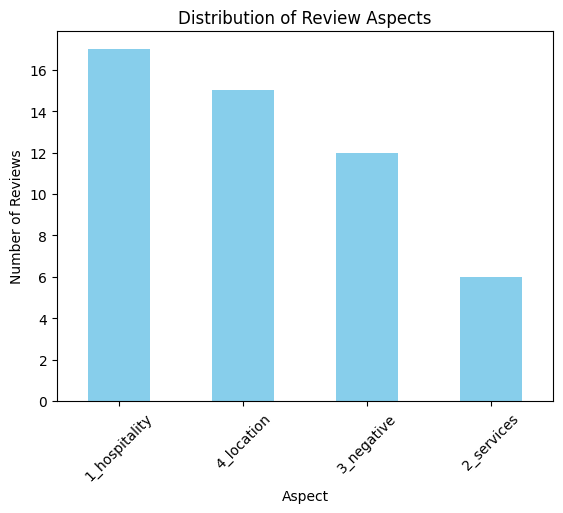

In [118]:
labeled_reviews['aspect'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Review Aspects')
plt.xlabel('Aspect')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

We can see that this dataset is imbalanced, with the majority of reviews falling into the "1. Positive feedback on hotel staff and hospitality" topic, and with only 5 reviews in the "2. Positive feedback on hotel amenities and services" topic.

### 6.3. Evaluating Clustering with Manual Labels

Now, we will use these manually labeled reviews to validate our clustering results. We will assign the topics identified by LDA to the reviews and compare them with the manually assigned labels.

In [119]:
new_counts = vectorizer.transform(labeled_reviews['review'])
topic_probs = lda.transform(new_counts)
assigned_topics = topic_probs.argmax(axis=1)

labeled_reviews['assigned_topic'] = assigned_topics
labeled_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,aspect,assigned_topic
0,697985229,3220199,Subhas Hotel,Jaffna,landed perfect hotel jaffna located prime loca...,4,4_location,1
1,1015796423,306381,Ramada by Wyndham Colombo,Colombo,great service stay great inusha madhavi prasan...,5,1_hospitality,0
2,827297036,5863531,Royal Castle,Negombo,honey moon night stayed two nights honeymoonwe...,5,2_services,1
3,997068714,23326905,Kenrish Hotel,Wadduwa,wcc 87 al batch getogether exciting moment ken...,5,4_location,3
4,1015645770,2510666,Jetwing Lagoon Wellness,Negombo,spa jetwing lagoon superb head shoulder foot m...,5,2_services,0


Here we can see that the labels assigned by LDA are numerical indices corresponding to the topics. We will map these indices to the topic names for better readability.

In [120]:
labeled_reviews['assigned_topic'] = labeled_reviews['assigned_topic'].astype(str)
labeled_reviews['assigned_topic'] = labeled_reviews['assigned_topic'].map({
    "0": "1_hospitality",
    "1": "2_services",
    "2": "3_negative",
    "3": "4_location"
})

labeled_reviews.head(20)

,review_id,location_id,hotel_name,city,review,rating,aspect,assigned_topic
0,697985229,3220199,Subhas Hotel,Jaffna,landed perfect hotel jaffna located prime loca...,4,4_location,2_services
1,1015796423,306381,Ramada by Wyndham Colombo,Colombo,great service stay great inusha madhavi prasan...,5,1_hospitality,1_hospitality
2,827297036,5863531,Royal Castle,Negombo,honey moon night stayed two nights honeymoonwe...,5,2_services,2_services
3,997068714,23326905,Kenrish Hotel,Wadduwa,wcc 87 al batch getogether exciting moment ken...,5,4_location,4_location
4,1015645770,2510666,Jetwing Lagoon Wellness,Negombo,spa jetwing lagoon superb head shoulder foot m...,5,2_services,1_hospitality
5,889286748,1160171,The Oasis Ayurveda Beach Resort,Hambantota,everything fine good people oasis hotel resort...,5,1_hospitality,3_negative
6,865299810,23587000,Earl's Rajarata,Anuradhapura,great hotel wonderful staff definitely returni...,5,1_hospitality,3_negative
7,1012507426,505588,Berjaya Hotel Colombo,Dehiwala-Mount Lavinia,great stay stay comfortable service welcoming ...,5,1_hospitality,1_hospitality
8,1014148799,316671,Mermaid Hotel & Club,Kalutara,wonderful stay mermaid hotel club went hotel a...,5,1_hospitality,1_hospitality
9,999901918,13336245,Ahas Gawwa,Padukka,quality time ahas gawwa place beautiful staff ...,5,4_location,4_location


Now, we can clearly see the assigned topics for each review. We can compare these with the manually assigned labels to evaluate the clustering performance.

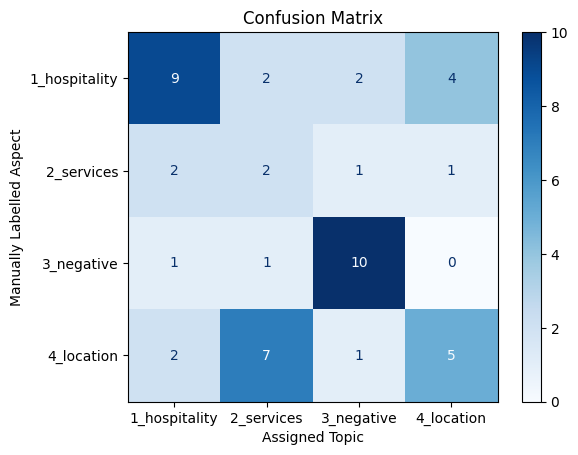

In [121]:
conf_matrix = confusion_matrix(labeled_reviews['aspect'], labeled_reviews['assigned_topic'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["1_hospitality", "2_services", "3_negative", "4_location"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Assigned Topic')
plt.ylabel('Manually Labelled Aspect')
plt.show()

As we can see from the confusion matrix, there are a significant number of classifications, especially for the `4_location` topic, that are misclassified as `2_services`. This indicates that the clustering is not perfect and there is some overlap between the topics.

Another explanation for this could be that the topics are not as distinct as we would like them to be, and there is some ambiguity in the reviews that makes it difficult to assign them to a single topic. We faced this same issue while manually labelling the reviews, as some reviews could be classified into multiple topics.

But for `1_hospitality` and `3_negative`, the clustering seems to be more accurate, with fewer misclassifications.

In [122]:
accuracy = accuracy_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'])
precision = precision_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average='weighted')
recall = recall_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average='weighted')
f1 = f1_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5200
Precision: 0.5600
Recall: 0.5200
F1 Score: 0.5287


Finally, we can summarize the performance of our clustering model using the usual performance metrics. We have an accuracy of 0.52, which is not very high, but it is better than random guessing. The precision, recall, and F1 score are also relatively low, indicating that the model is not performing well in distinguishing between the different topics.

We can also use the Rand Index and Jaccard Coefficient to evaluate the clustering performance.

In [123]:
rand_index = rand_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'])
print(f"Rand Index: {rand_index:.4f}")

Rand Index: 0.6988


In [124]:
jaccard_coefficient = jaccard_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average="macro")
print(f"Jaccard Coefficient: {jaccard_coefficient:.4f}")

Jaccard Coefficient: 0.3523


For Rand Index, we receive a value of 0.6988, which indicates a moderate level of agreement between the clustering and the manual labels.

For Jaccard Coefficient, we receive a value of 0.3523, which indicates a low level of agreement between the clustering and the manual labels. Since this metric is based on the size of the intersection and union of the sets - we can expect this score to be lower as the dataset is not very distinct and there is a significant amount of overlap between the topics. 

### 6.4. Implementing an Aspect Based Sentiment Classifier 


Now, we can use the LDA model we trained in 6.3, to assign cluster labels for all of the reviews.

In [125]:
reviews = pd.read_csv('cleaned_reviews.csv')

counts = vectorizer.transform(reviews['review'])
topic_probs = lda.transform(counts)
assigned_topics = topic_probs.argmax(axis=1)
reviews["aspect"] = assigned_topics
reviews["aspect"] = reviews["aspect"].astype(str)
reviews["aspect"] = reviews["aspect"].map({
    "0": "1_hospitality",
    "1": "2_services",
    "2": "3_negative",
    "3": "4_location"
})

reviews.head()

,review_id,location_id,hotel_name,city,review,rating,aspect
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,3_negative
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,2_services
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,2_services
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,2_services
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1_hospitality


Since in task 3 and 4, we observed that the best performance for the classification model appeared when we used a Word2Vec embeddings with a Support Vector Machine, we will be doing the same for this task as well to create an aspect based sentiment classifier. 

In [126]:
word2vec_data = pd.read_csv('feature_matrix_word2vec.csv')
ground_truth = reviews['aspect'].values

In [127]:
def classifier(features, ground_truth, name, clf):
    y_pred = cross_val_predict(clf, features, ground_truth, cv=5)
    print(f'Accuracy for {name}: {accuracy_score(ground_truth, y_pred):.4f}')
    print(f"Precision for {name}: {precision_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"Recall for {name}: {recall_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"F1 Score for {name}: {f1_score(ground_truth, y_pred, average='weighted'):.4f}")

    cm = confusion_matrix(ground_truth, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(text_kw={'color': 'black'})
    plt.title(f'Confusion Matrix for {name} Features')
    plt.show()

    return f1_score(ground_truth, y_pred, average='weighted')

And now we can run this model against the established ground truth labels to see how well it performs.

Accuracy for Word2Vec: 0.8916
Precision for Word2Vec: 0.8923
Recall for Word2Vec: 0.8916
F1 Score for Word2Vec: 0.8917


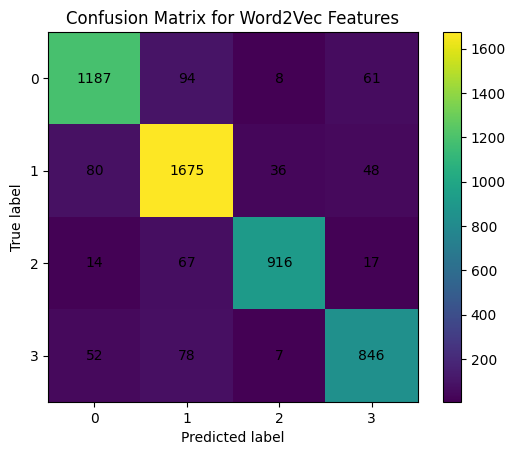

0.8917355182703203

In [128]:
classifier(word2vec_data, ground_truth, "Word2Vec", SVC(kernel='linear'))

As it can be seen above, this model performs quite well, with an accuracy and F1-score over 89%. This is expected as the LDA model assigned reviews to a cluster based on the keywords present within it. This model is able to capture that same information quite well. 